In [154]:
import ee
import geemap
from geemap import cartoee
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

In [155]:
def setup():
    ee.Authenticate()
    ee.Initialize()
setup()

Enter verification code:  4/1AX4XfWiK2SKSJh0jhDEe41W9zq8_0qTGxNUfoSdpxjikEdGAFsU3cPwNFa8



Successfully saved authorization token.


In [164]:
# set up region of interest
# defining the location where we want to extract the data
poi_coords = [10.0523,106.1664]  # mekong delta
box_size = 0.5  # in degrees

# calculate a box around the point of interest
bbox_coord = [poi_coords[1]-box_size,poi_coords[0]-box_size,poi_coords[1]+box_size,poi_coords[0]+box_size]
poi = ee.Geometry.Point(poi_coords[::-1])  # ee geometry needs long, lat so list is reversed using python string slicing

# use a ee geometry to pass to the filterBounds
roi = ee.Geometry.BBox(*bbox_coord)

# Step 1 Data loading and preprocessing 
- Load the Copernicus Sentinel-2 surface reflectance data (COPERNICUS/S2_SR) over  a region of your interest and apply the necessary pre-processing steps (e.g. filtering for cloud cover, masking clouds based on QA60 bitmask)

In [165]:
def masks2(image):
    return image.updateMask(image.select('QA60').eq(0))

sr = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(roi).filterDate('2019-01-01','2020-01-01').filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50).map(masks2)

composite = sr.median().clip(roi)

# Step 2 Supervised classification 
- Sample the Copernicus 100m Landcover product (COPERNICUS/Landcover/100m/Proba-V-C3/Global) to get training data of landcover classes to classify the Sentinel-2 data over your region of interest. 
- Split your training data into a training and testing subset 
- Apply 3 different supervised classifiers (Classification and Regression Trees, Random Forest, and Support Vector Machine) to one image of your data set. 
- Assess the accuracy for the different classifiers on both training and test data. 

In [166]:
# we load the landcover image for 2019
landcover_image = ee.Image('COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019').clip(roi)
# Of all the bands, we area interested in the classification. Therefore we select out the classification band
class_data = landcover_image.select('discrete_classification')

# we will use these bands for classification
bands = ['B2', 'B3', 'B4', 'B8', 'B11',]
#bands = ['B1','B2', 'B3', 'B4','B5','B6','B7','B8','B9','B11']

# we set this as a constant because we will use it a lot
Truecolorvis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}


In [167]:
# going to do this using a function to avoid extra copying and pasting
def trainingsplit(sample_data,split):
    sample_data = sample_data.randomColumn()
    training_data = sample_data.filter(ee.Filter.lessThan('random',split))
    validation_data = sample_data.filter(ee.Filter.greaterThanOrEquals('random',split))
    return training_data,validation_data


In [168]:
# to create a readable confusion matrix we need to change the indexes of the landcover dataset

class_name_list = class_data.get('discrete_classification_class_names').getInfo()
# only get the string before the period so that its not too long
class_name_list = [x.split('.')[0] for x in class_name_list]
class_value_list = class_data.get('discrete_classification_class_values').getInfo()
sequential_class_list = list(range(len(class_value_list)))


# change to sequential mapping
class_data = class_data.remap(class_value_list,sequential_class_list).rename('discrete_classification')


## CART Classifier

In [171]:
# Create a new map
m = geemap.Map(center = poi_coords,zoom=10)
# Add the composite true color image
m.addLayer(composite,Truecolorvis,'True Color')
# add the ground truth data about the class
m.addLayer(class_data,{'bands':'discrete_classification'},'Reference classification')



# this line is complicated but it adds the class data to the composite, then takes 5000 samples
sample = composite.select(bands).addBands(class_data).sample(
    numPixels =20000,
    scale = 10,
    #tileScale=2,
    geometries=True,
)

# python unpacking into the trainging and validation split
training_data,validation = trainingsplit(sample,0.7)

# check that the process has worked correctly
print('training data size',training_data.size().getInfo())
print('validation data size',validation.size().getInfo())

# create a Cart classifier
classifier = ee.Classifier.smileCart().train(
  features=training_data,
  classProperty = 'discrete_classification',
  inputProperties=bands
  )

# use the previously created classified 
classified = composite.classify(classifier)

training_accuracy = classifier.confusionMatrix()

validated = validation.classify(classifier)

test_accuracy = validated.errorMatrix('discrete_classification','classification')

print(f'Training accuracy: {training_accuracy.accuracy().getInfo()}' )
print(f'validation overall accuracy: {test_accuracy.accuracy().getInfo()}')


df = pd.DataFrame(test_accuracy.getInfo(),columns=class_name_list)

df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

training data size 14073
validation data size 5922
Training accuracy: 1
validation overall accuracy: 0.4880108071597433


,Unknown,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation / agriculture,Urban / built up,Bare / sparse vegetation,Snow and ice,Permanent water bodies,Herbaceous wetland,Moss and lichen,"Closed forest, evergreen needle leaf","Closed forest, evergreen broad leaf","Closed forest, deciduous needle leaf","Closed forest, deciduous broad leaf","Closed forest, mixed","Closed forest, not matching any of the other definitions","Open forest, evergreen needle leaf","Open forest, evergreen broad leaf","Open forest, deciduous needle leaf","Open forest, deciduous broad leaf","Open forest, mixed","Open forest, not matching any of the other definitions","Oceans, seas"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,2,18,2,0,0,5,11,0,0,1,0,0,0,1,0,0,0,0,0,1,3
2,0,2,2,4,2,0,0,1,4,0,0,1,0,0,0,1,0,0,0,0,0,2,3
3,0,25,6,1917,193,2,0,19,60,0,0,249,0,0,0,70,0,84,0,0,0,223,28
4,0,2,1,169,119,1,0,6,16,0,0,41,0,0,0,5,0,23,0,0,0,46,8
5,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,4,2,16,11,0,0,89,15,0,0,1,0,0,0,0,0,1,0,0,0,3,68
8,0,13,0,75,12,3,0,16,38,0,0,5,0,0,0,2,0,1,0,0,0,12,7
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [172]:
m.add_ee_layer(classified,{'min':0,'max':22},'Classification Result')

m

Map(center=[10.0523, 106.1664], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

## Random Forest

In [173]:
# Create a new map
m = geemap.Map(center = poi_coords,zoom=6)

# Add the composite true color image
m.addLayer(composite,Truecolorvis,'True Color')
# add the ground truth data about the class
m.addLayer(class_data,{'bands':'discrete_classification'},'Reference classification')



# this line is complicated but it adds the class data to the composite, then takes 5000 samples
sample = composite.select(bands).addBands(class_data).sample(
    numPixels =20000,
    scale = 10,
    #tileScale=2,
    geometries=True,
)

# python unpacking into the trainging and validation split
training_data,validation = trainingsplit(sample,0.7)

# check that the process has worked correctly
print('training data size',training_data.size().getInfo())
print('validation data size',validation.size().getInfo())

# create a Cart classifier
classifier = ee.Classifier.smileRandomForest(100).train(
  features=training_data,
  classProperty = 'discrete_classification',
  inputProperties=bands
  )

# use the previously created classified 
classified = composite.classify(classifier)

training_accuracy = classifier.confusionMatrix()

validated = validation.classify(classifier)

test_accuracy = validated.errorMatrix('discrete_classification','classification')

print(f'Training accuracy: {training_accuracy.accuracy().getInfo()}' )
print(f'validation overall accuracy: {test_accuracy.accuracy().getInfo()}')


df = pd.DataFrame(test_accuracy.getInfo(),columns=class_name_list)

df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

training data size 14073
validation data size 5922
Training accuracy: 0.9909045690328999
validation overall accuracy: 0.624451198919284


,Unknown,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation / agriculture,Urban / built up,Bare / sparse vegetation,Snow and ice,Permanent water bodies,Herbaceous wetland,Moss and lichen,"Closed forest, evergreen needle leaf","Closed forest, evergreen broad leaf","Closed forest, deciduous needle leaf","Closed forest, deciduous broad leaf","Closed forest, mixed","Closed forest, not matching any of the other definitions","Open forest, evergreen needle leaf","Open forest, evergreen broad leaf","Open forest, deciduous needle leaf","Open forest, deciduous broad leaf","Open forest, mixed","Open forest, not matching any of the other definitions","Oceans, seas"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,28,0,0,0,6,9,0,0,1,0,0,0,0,0,0,0,0,0,0,2
2,0,1,0,8,0,0,0,2,6,0,0,1,0,0,0,0,0,0,0,0,0,2,2
3,0,1,0,2575,78,0,0,18,33,0,0,139,0,0,0,0,0,4,0,0,0,25,3
4,0,0,0,237,131,0,0,9,15,0,0,30,0,0,0,0,0,4,0,0,0,10,1
5,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,17,2,0,0,103,18,0,0,0,0,0,0,0,0,0,0,0,0,0,70
8,0,2,0,94,5,0,0,8,67,0,0,3,0,0,0,0,0,0,0,0,0,0,5
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [174]:
m.add_ee_layer(classified,{'min':0,'max':22},'Classification Result')

m

Map(center=[10.0523, 106.1664], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

## SVM

In [176]:
# Create a new map
m = geemap.Map(center = poi_coords,zoom=6)

# Add the composite true color image
m.addLayer(composite,Truecolorvis,'True Color')
# add the ground truth data about the class
m.addLayer(class_data,{'bands':'discrete_classification'},'Reference classification')



# this line is complicated but it adds the class data to the composite, then takes 5000 samples
sample = composite.select(bands).addBands(class_data).sample(
    numPixels =5000,
    scale = 10,
    #tileScale=2,
    geometries=True,
)

# python unpacking into the trainging and validation split
training_data,validation = trainingsplit(sample,0.7)

# check that the process has worked correctly
print('training data size',training_data.size().getInfo())
print('validation data size',validation.size().getInfo())

# create a Cart classifier
classifier = ee.Classifier.libsvm().train(
  features=training_data,
  classProperty = 'discrete_classification',
  inputProperties=bands
  )

# use the previously created classified 
classified = composite.classify(classifier)

training_accuracy = classifier.confusionMatrix()

validated = validation.classify(classifier)

test_accuracy = validated.errorMatrix('discrete_classification','classification')

print(f'Training accuracy: {training_accuracy.accuracy().getInfo()}' )
print(f'validation overall accuracy: {test_accuracy.accuracy().getInfo()}')


df = pd.DataFrame(test_accuracy.getInfo(),columns=class_name_list)

df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

training data size 3540
validation data size 1458


KeyboardInterrupt: 

In [ ]:
m.add_ee_layer(classified,{'min':0,'max':22},'Classification Result')

m

# Step 3 Unsupervised classification 
## Apply an unsupervised K-means classification to the same image of Step 2 and vary the number of clusters 

In [ ]:
def perform_kmeans(num_clusters):
    m = geemap.Map(center = poi_coords,zoom=10)

    sample = composite.select(bands).sample(
        numPixels =10000,
        scale = 10,
        #tileScale=2,
        #geometries=True,
    )

    clusterer = ee.Clusterer.wekaKMeans(nClusters = num_clusters).train(sample)

    clustered = composite.cluster(clusterer)
    m.add_ee_layer(composite,Truecolorvis,'True Color')
    m.add_ee_layer(clustered.randomVisualizer(),{},f'Classification Result - {num_clusters} Clusters')

    return m

### 5 clusters

In [ ]:
perform_kmeans(5)

### 10 clusters

In [ ]:
perform_kmeans(10)

### 15 clusters

In [ ]:
perform_kmeans(15)

### 22 clusters

In [ ]:
perform_kmeans(22)

# Step 4 Multi-temporal classification 
## Apply the best classifier of Step 2 to a set of Sentinel-2 images (e.g. a year over your ROI) using the map-command. Use two different approaches: 

The best classifier, based on validation accuracy, is the random forest classifier with 100 trees to start. This classifier will also work better becuase it is faster to train than other other classifiers in step 2
### Train a classifier on one image and apply it to all images in your set. 

In [222]:
# for this part we will train on one and apply it to the others. 
# this line is complicated but it adds the class data to the composite, then takes 10000 samples
one_image = sr.first()


# get the landcover data for the area of the image
truthdata = class_data.clip(one_image.geometry())

# 
training_data = one_image.select(bands).addBands(truthdata).sample(
numPixels =10000,
scale = 10,
#tileScale=2,
)

# create a Cart classifier
classifier = ee.Classifier.smileRandomForest(100).train(
  features=training_data,
  classProperty = 'discrete_classification',
  inputProperties=bands
  )

In [223]:
m = geemap.Map(center = poi_coords,zoom=10)
m.add_ee_layer(one_image.classify(classifier).randomVisualizer(),{},'s4 part1')
m

Map(center=[10.0523, 106.1664], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [224]:
def s4_part1(image):
    
    # classify the image using the classifier trained above
    classified = image.classify(classifier)
    
    # clip the land cover data to the image
    truthdata = class_data.clip(image.geometry())
    
    # add the truth data image to the classified image, sample it, calculate the error matrix accuracy parameter 
    val_accuracy  = classified.addBands(truthdata).sample(numPixels=5000,scale=10).errorMatrix('discrete_classification','classification').accuracy()
    
    # assign the accuracy as a property of that image
    classified = classified.set('validAccuracy',val_accuracy)
    
    # return that image
    return classified

In [225]:
s4_part1_IC = sr.map(s4_part1)
print(f'Number of images in collection: {s4_part1_IC.size().getInfo()}')
print(f'The maximum accuracy is: {s4_part1_IC.aggregate_max("validAccuracy").getInfo()}')
print(f'The minimum accuracy is: {s4_part1_IC.aggregate_min("validAccuracy").getInfo()}')
hist_dict = s4_part1_IC.aggregate_histogram('validAccuracy').getInfo()



Number of images in collection: 204
The maximum accuracy is: 0.9935379644588045
The minimum accuracy is: 0.2982456140350877


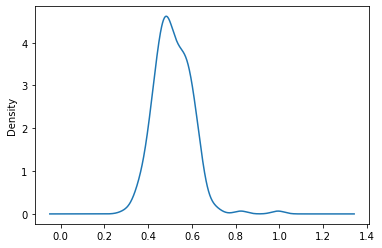

In [226]:
df = pd.DataFrame(hist_dict.items(),columns=['bin','count'])
ax1 = df.bin.astype('float64').plot(kind='kde')

### Train and apply the classifier on every individual image 

In [227]:
def s4_part2(image):
    
    # get the landcover data for the area of the image
    truthdata = class_data.clip(image.geometry())
    
    # 
    training_data = image.select(bands).addBands(truthdata).sample(
    numPixels =10000,
    scale = 10,
    #tileScale=2,
    )

    # create a Cart classifier, train it on the sample data
    classifier = ee.Classifier.smileRandomForest(100).train(
      features=training_data,
      classProperty = 'discrete_classification',
      inputProperties=bands
      )
    
    # classify the image using the classifier trained above
    classified = image.classify(classifier)   
    
    # add the truth data image to the classified image, sample it, calculate the error matrix accuracy parameter 
    val_accuracy  = classified.addBands(truthdata).sample(numPixels=5000,scale=10).errorMatrix('discrete_classification','classification').accuracy()
    
    # assign the accuracy as a property of that image
    classified = classified.set('validAccuracy',val_accuracy)
    
    # return that image
    return classified

In [ ]:
s4_part2_IC = sr.map(s4_part2)
print(f'Number of images in collection: {s4_part2_IC.size().getInfo()}')
print(f'The maximum accuracy is: {s4_part2_IC.aggregate_max("validAccuracy").getInfo()}')
hist_dict_2 = s4_part2_IC.aggregate_histogram('validAccuracy').getInfo()

Number of images in collection: 204


In [ ]:
df2 = pd.DataFrame(hist_dict_2.items(),columns=['bin','count'])
df2.bin.astype('float64').plot(kind='kde')

In [ ]:
ax2 = df2.bin.astype('float64').plot(kind='kde',ax=ax1)
ax2.get_figure().savefig('error_Density.png',facecolor='w',bbox_inches='tight')

##  Q3: Illustrate the difference in accuracy between the different approaches and explain why?

# Step 5 Contextual classification 
## Apply the best classifier of Step 2, but try to improve the accuracy by adding contextual information to the classifier. This can be done by computing the texture etrics from the Gray Level Co-occurrence Matrix and add that information to your classifier. 

In [216]:
# Create a new map
m = geemap.Map(center = poi_coords,zoom=6)# Add the composite true color image
m.addLayer(composite,Truecolorvis,'True Color')
# add the ground truth data about the class
m.addLayer(class_data,{'bands':'discrete_classification'},'Reference classification')

# as part of step 5 we add all the bands from the GLCM, and we print them just to ensure that the code is working correctly
GCLM_bands = composite.select('B8').toInt32().glcmTexture(size=4)


# we need a list of bands of the GCLM output
s5_bandlist = GCLM_bands.bandNames().getInfo()
print('The following bands were added from the GCLM results',s5_bandlist)

# we need to combine the GCLM and regular bands
all_bands = bands+s5_bandlist
print('The bands we will use to train the classifier',all_bands)

# we will add those bands to the oringal image and use the results for the rest of step 5
step5_composite = composite.select(bands).addBands(GCLM_bands)

# check that the image we are using has all the bands we need, so raise an error if we have an issue 
assert step5_composite.bandNames().getInfo() == all_bands

The following bands were added from the GCLM results ['B8_asm', 'B8_contrast', 'B8_corr', 'B8_var', 'B8_idm', 'B8_savg', 'B8_svar', 'B8_sent', 'B8_ent', 'B8_dvar', 'B8_dent', 'B8_imcorr1', 'B8_imcorr2', 'B8_maxcorr', 'B8_diss', 'B8_inertia', 'B8_shade', 'B8_prom']
The bands we will use to train the classifier ['B2', 'B3', 'B4', 'B8', 'B11', 'B8_asm', 'B8_contrast', 'B8_corr', 'B8_var', 'B8_idm', 'B8_savg', 'B8_svar', 'B8_sent', 'B8_ent', 'B8_dvar', 'B8_dent', 'B8_imcorr1', 'B8_imcorr2', 'B8_maxcorr', 'B8_diss', 'B8_inertia', 'B8_shade', 'B8_prom']


In [217]:
# select the bands we are interested in, add the GCLM bands we found in the cell above, add the ground truth classification data, take 20000 samples of the resulting image

sample = step5_composite.addBands(class_data).sample(
    numPixels = 200,
    scale = 10,
    tileScale=2,
    #geometries=True,
)
#print('Number of samples generated: ',sample.size().getInfo())

In [218]:
# python unpacking into the training and validation split
training_data,validation = trainingsplit(sample,0.7)

In [219]:
# create a Cart classifier
classifier = ee.Classifier.smileRandomForest(14).train(
  features=training_data,
  classProperty = 'discrete_classification',
  inputProperties=all_bands
  )

classified = step5_composite.classify(classifier)

training_accuracy = classifier.confusionMatrix()

validated = validation.classify(classifier)

test_accuracy = validated.errorMatrix('discrete_classification','classification')

m.add_ee_layer(classified,{'min':0,'max':22},'Classification Result')

m

Map(center=[10.0523, 106.1664], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

In [220]:
# check that the process has worked correctly
print('training data size',training_data.size().getInfo())
print('validation data size',validation.size().getInfo())
training_accuracy = classifier.confusionMatrix()
print(f'Training accuracy: {training_accuracy.accuracy().getInfo()}' )
print(f'validation overall accuracy: {test_accuracy.accuracy().getInfo()}')

training data size 145
validation data size 56
Training accuracy: 0.9411764705882353
validation overall accuracy: 0.5


In [221]:
df = pd.DataFrame(test_accuracy.getInfo(),columns=class_name_list)

df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})


,Unknown,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation / agriculture,Urban / built up,Bare / sparse vegetation,Snow and ice,Permanent water bodies,Herbaceous wetland,Moss and lichen,"Closed forest, evergreen needle leaf","Closed forest, evergreen broad leaf","Closed forest, deciduous needle leaf","Closed forest, deciduous broad leaf","Closed forest, mixed","Closed forest, not matching any of the other definitions","Open forest, evergreen needle leaf","Open forest, evergreen broad leaf","Open forest, deciduous needle leaf","Open forest, deciduous broad leaf","Open forest, mixed","Open forest, not matching any of the other definitions","Oceans, seas"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,33,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Compare the accuracy metrics for the contextual approach with the earlier approaches. 
## Q4: Illustrate the effect of adding the GLCM information to your classifier and explain which variables have a positive or negative effect on the classifier. Motivate your explanation. 

# Step 6 OBIA classification 
## Perform an image segmentation by applying the SNIC algorithm to your image of step 2 
## Apply the best classifier of Step 2 to your segmented objects where each object is classified based on the per-cluster averages reflectance.  
## Compare the accuracy metrics for the SNIC-classification approach with the earlier approaches. 
## Add per-cluster properties to your classifier (e.g. standard deviation, area) and repeat the classifier/accuracy assessment 
## Q5: Illustrate the effect of the SNIC algorithm and the integration of per-cluster properties on the classification accuracy and explain why? Also motivate your SNIC-algorithm settings.  

# Step 7 Discussion 
## Q6: Discuss what other approaches and improvements could be helpful to increase the performance of the classifier. 